# Tutorial: GPFA (Gaussian Process Factor Analysis)

Gaussian-process factor analysis (GPFA) is a dimensionality reduction method
[1] for neural trajectory visualization of parallel spike trains. GPFA applies
factor analysis (FA) time-binned spike count data to reduce the dimensionality
and at the same time smoothes the resulting low-dimensional trajectories by
fitting a Gaussian process (GP) model to them.

The input consists of a set of trials (Y), each containing a list of spike
trains (N neurons). The output is the projection (X) of the data in space
of pre-chosen dimension $x_{dim} < N$.

Under the assumption of a linear relation between the latent variable X and the
actual data Y in addition to a noise term (i.e., $Y = C * X + d + \mathcal{N}(0,R)$), the projection corresponds to the
conditional probability $E[X|Y]$.

A Gaussian process (X) of dimension $x_{dim} < N$ is adopted to extract smooth
neural trajectories. The parameters (C, d, R) are estimated from the data using
factor analysis technique.

Internally, the analysis consists of the following steps:

0) bin the data to get a sequence of `N` dimensional vectors of spike counts for
   each time bin, and choose the reduced dimension `x_dim`

1) expectation maximization for the parameters `C`, `d`, `R` and the time-scale of
   the Gaussian process, using all the trials provided as input (cf.,
   `gpfa_core.em()`)

2) projection of single trials in the low dimensional space (cf.,
   `gpfa_core.exact_inference_with_ll()`)

3) orthonormalization of the matrix `C` and the corresponding subspace:
   (cf., `gpfa_core.orthonormalize()`)



References
----------
The code was ported from the MATLAB code based on Byron Yu's implementation.
The original MATLAB code is available at Byron Yu's website:
https://users.ece.cmu.edu/~byronyu/software.shtml

    [1] Yu MB, Cunningham JP, Santhanam G, Ryu SI, Shenoy K V, Sahani M (2009) Gaussian-process factor analysis for low-dimensional single-trial analysis of neural population activity. J Neurophysiol 102:614-635.

## Idea of this Tutorial

This tutorial illustrates the usage of the GPFA class implemented in elephant.

The example was inspired by the supplementary material of:
    
    [2] Pandarinath, C. et al. Inferring single-trial neural population dynamics using sequential auto-encoders. Nat. Methods 15, 805–815 (2018).

### Generation of synthetic spiketrains

First a set of spiketrains will be created. The trajectories obtained from either a 2D-harmonic oscillator or a 3D-Lorentz attractor (used parametrization taken from https://en.wikipedia.org/wiki/Lorenz_system) will be projected into a high-dimensional space via random projection. The resulting high-dimensional trajectories serve as instantaneous rates for an inhomogeneous Poisson process which in turn yields synthetic spiketrains. The list of spiketrains will serve as input data to the GPFA.

### `fit()` and `transform()` methods

In this scenario we use one dataset to fit the model and to extract the neural trajectories. The parameters that describe the transformation are first extracted from the data using the `fit()` method of the `GPFA` class. Then the same data is projected into the orthonormal basis using the method `transform()`. The `fit_transform()` method can be used to perform these two steps at once.

We start with importing the packages and writing two utility functions - `random_projection` and `generate_spiketrains`, - which will we use later on.

In [2]:
import elephant
from elephant.spike_train_generation import inhomogeneous_poisson_process
import quantities as pq
import neo

import numpy as np
from scipy.integrate import odeint

from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray 
       Random (normal) projection of input data, shape=(dim, N)
       
    See Also
    --------
    np.random.normal()
    
    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """    
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep : 
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).
        
    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.
    
    """
    
    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)
        
    return spiketrains

## 1. Harmonic Oscillator

### 1.1. Simulating 2-dim Harmonic Oscillator and projecting into 20-dim space

In [4]:
def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """    
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float 
        Initial values in three dimensional space.
    angular_frequency : float 
        Angular frequency in 1/ms.
    
    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """ 
    
    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))

In [5]:
# set parameters for the integration of the harmonic oscillator
timestep = 1*pq.ms
trial_duration = 20*pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# specify data
num_trials = 10
num_spiketrains = 20

# calculate the oscillator
time, oscillator_trajectory_2D = integrated_oscillator(timestep.magnitude,
                                                       num_steps=num_steps,
                                                       x0=0,
                                                       y0=1)

# random projection
oscillator_trajectory_ND = random_projection(oscillator_trajectory_2D,
                                             embedding_dimension=num_spiketrains)

# calculate instantaneous rate
max_rate = 50*pq.Hz
min_oscillator_trajectory_ND = np.amin(oscillator_trajectory_ND)
max_oscillator_trajectory_ND = np.amax(oscillator_trajectory_ND)
normed_input = (oscillator_trajectory_ND - min_oscillator_trajectory_ND) / (max_oscillator_trajectory_ND - min_oscillator_trajectory_ND)
instantaneous_rates_oscillator = normed_input * max_rate
print(f'Maximal Rate: {np.max(instantaneous_rates_oscillator.rescale("Hz").magnitude)}')


# generate spiketrains
synthetic_spiketrains_oscillator = generate_spiketrains(instantaneous_rates_oscillator,
                                                        num_trials,
                                                        timestep)


Maximal Rate: 50.0


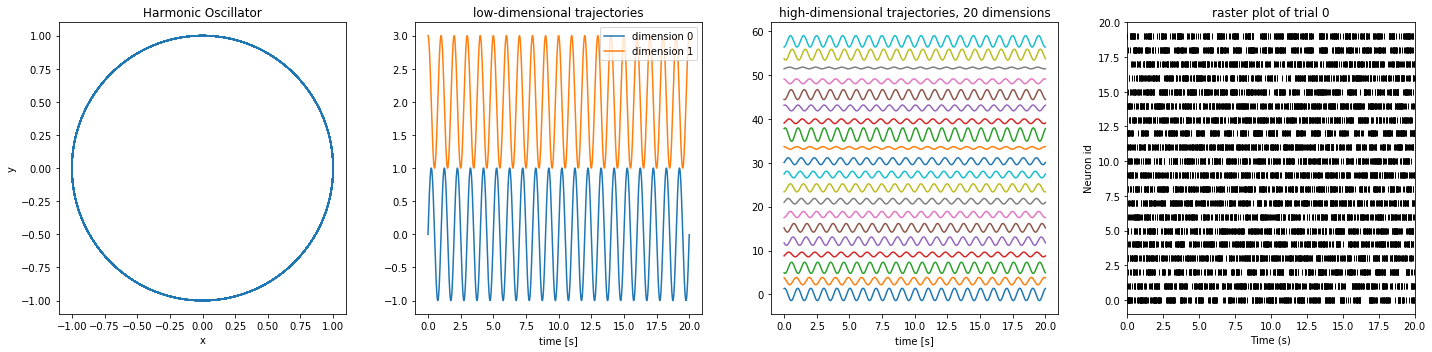

In [6]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))

ax1.plot(oscillator_trajectory_2D[0], oscillator_trajectory_2D[1])
ax1.set_title('Harmonic Oscillator')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

for i, x in enumerate(oscillator_trajectory_2D):
    ax2.plot(time*timestep.rescale('s'), x+i*(np.max(oscillator_trajectory_2D)-np.min(oscillator_trajectory_2D)), label=f'dimension {i}')
ax2.set_xlabel('time [s]')
ax2.set_title('low-dimensional trajectories')
ax2.legend()

for i, x in enumerate(oscillator_trajectory_ND):
    ax3.plot(time*timestep.rescale('s'), x+i*(np.max(oscillator_trajectory_ND)-np.min(oscillator_trajectory_ND)))
ax3.set_xlabel('time [s]')
ax3.set_title(f'high-dimensional trajectories, {num_spiketrains} dimensions')

trial_to_plot = 0
for i, spiketrain in enumerate(synthetic_spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|', color='k')
ax4.set_xlim([0, trial_duration.rescale('s').magnitude])
ax4.set_ylim([-1, num_spiketrains])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
ax4.set_title(f'raster plot of trial {trial_to_plot}')

plt.tight_layout()
plt.show()

In the example above, two-dimensional Harmonic Oscillator is projected into 20-dimensional space. Each dimension is described by neuronal activity, shown right. Now we want to recreate the original two-dimensional space, that fully describes the behavior of Harmonic Oscillator.


### 1.2. Applying GPFA to find low-dimensional subspace

Initialize an instance of the class (here explicitely with all default parameters):

In [7]:
gpfa = GPFA(bin_size=20 * pq.ms, x_dim=2, min_var_frac=0.01,
            tau_init=100.0 * pq.ms, eps_init=1.0E-3, em_tol=1.0E-8,
            em_max_iters=500, freq_ll=5, verbose=False)

#### 1.2.1. Fit a GPFA model onto the data

In [8]:
gpfa.fit(synthetic_spiketrains_oscillator)

Initializing parameters using factor analysis...

Fitting GPFA model...


GPFA(bin_size=array(20.) * ms, em_max_iters=500, em_tol=1e-08, eps_init=0.001,
     freq_ll=5, min_var_frac=0.01, tau_init=array(100.) * ms, verbose=False,
     x_dim=2)

#### 1.2.2. Project the data into the orthonormalized latent variable space

In [9]:
result = gpfa.transform(synthetic_spiketrains_oscillator, returned_data=['xorth', 'xsm', 'Vsm', 'VsmGP', 'y'])

In [10]:
print(result.keys())
xorth = result['xorth']

dict_keys(['xorth', 'xsm', 'Vsm', 'VsmGP', 'y'])


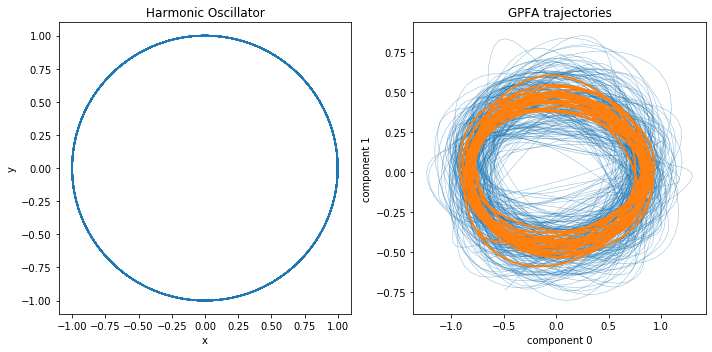

In [11]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.plot(oscillator_trajectory_2D[0], oscillator_trajectory_2D[1])
ax1.set_title('Harmonic Oscillator')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# single trial trajectories
for i in range(num_trials):
    ax2.plot(xorth[i][0], xorth[i][1], '-', linewidth=linewidth_single_trial, color=color_single_trial, alpha=alpha_single_trial)

    # trial averaged trajectories
average_trajectories = np.zeros_like(xorth[0])
for i in range(num_trials):
    average_trajectories += xorth[i]
average_trajectories /= num_trials
ax2.plot(average_trajectories[0], average_trajectories[1], '-', linewidth=linewidth_trial_average, color=color_trial_average)
ax2.set_title('GPFA trajectories')
ax2.set_xlabel('component 0')
ax2.set_ylabel('component 1')

plt.tight_layout()
plt.show()

GPFA could find 2-dim embedding space that describes Harmonic Oscillator behavior.

## 2. Lorentz Attractor

### 2.1. Simulating 3-dim Lorentz Attractor and projecting into 50-dim space

In [12]:
def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
    """
    Fit the model with `spiketrains` data and apply the dimensionality
    reduction on `spiketrains`.

    Parameters
    ----------
    point_of_interest : tuple
        Tupel containing coordinates (x,y,z) in three dimensional space. 
    timepoint : a point of interest in time
    dt : 
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    sigma, rho, beta : float 
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    x_dot, y_dot, z_dot : float 
        Values of the lorenz attractor's partial derivatives
        at the point x, y, z.
    """
    
    x, y, z = point_of_interest

    x_dot = (sigma*(y - x)) / tau
    y_dot = (rho*x - y - x*z) / tau
    z_dot = (x*y - beta*z) / tau
    return x_dot, y_dot, z_dot


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """
    
    Parameters
    ----------
    dt : 
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float 
        Initial values in three dimensional space
    sigma, rho, beta : float 
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms
    
    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    
    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T

In [13]:
# set parameters for the integration of the Lorentz attractor
np.random.seed(36) # to ensure that 3D plotting angle is chosen correctly

# Note: the initial evolution of the Lorentz attractor is transient and
# will be skipped for the spiketrain generation
timestep = 1*pq.ms
transient_duration = 1*pq.s
trial_duration = 25*pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# specify data
num_trials = 20
num_spiketrains = 50

# calculate the oscillator
time_with_transient, lorentz_trajectory_3D = integrated_lorenz(timestep,
                                                num_steps=num_steps_transient+num_steps,
                                                x0=0,
                                                y0=1,
                                                z0=1.25)

time = time_with_transient[num_steps_transient:]-transient_duration

# random projection
lorentz_trajectory_ND = random_projection(lorentz_trajectory_3D[:, num_steps_transient:],
                                          embedding_dimension=num_spiketrains)

# calculate instantaneous rate
# an additional non-linearity is used to enhance the signal
instantaneous_rates_lorentz = np.power(1.08, lorentz_trajectory_ND)
print(f'Maximal Rate: {np.max(instantaneous_rates_lorentz)}')

# generate spiketrains
synthetic_spiketrains_lorentz = generate_spiketrains(instantaneous_rates_lorentz,
                                                        num_trials,
                                                        timestep)

Maximal Rate: 115.59695387162101


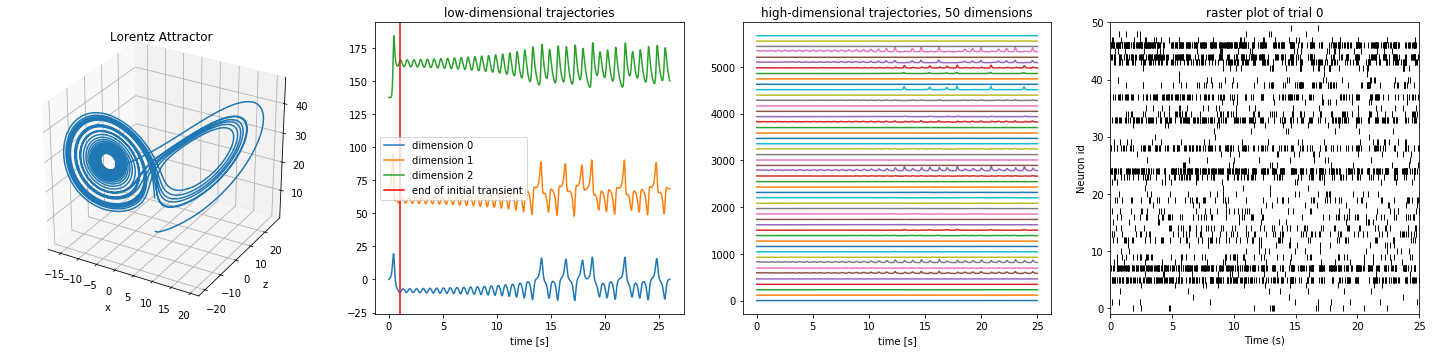

In [14]:
f = plt.figure(figsize=(20,5))
ax1 = f.add_subplot(1, 4, 1, projection='3d')
ax2 = f.add_subplot(1, 4, 2)
ax3 = f.add_subplot(1, 4, 3)
ax4 = f.add_subplot(1, 4, 4)

ax1.plot(lorentz_trajectory_3D[0], lorentz_trajectory_3D[1], lorentz_trajectory_3D[2])
ax1.set_title('Lorentz Attractor')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_ylabel('z')

for i, x in enumerate(lorentz_trajectory_3D):
    ax2.plot(time_with_transient*timestep.rescale('s'), x+i*(np.max(lorentz_trajectory_3D)-np.min(lorentz_trajectory_3D)), label=f'dimension {i}')
ax2.axvline(transient_duration.rescale('s').magnitude, color='r',label='end of initial transient')
ax2.set_xlabel('time [s]')
ax2.set_title('low-dimensional trajectories')
ax2.legend()

for i, x in enumerate(instantaneous_rates_lorentz):
    ax3.plot(time*timestep.rescale('s'), x+i*(np.max(instantaneous_rates_lorentz)-np.min(instantaneous_rates_lorentz)))
ax3.set_xlabel('time [s]')
ax3.set_title(f'high-dimensional trajectories, {num_spiketrains} dimensions')

trial_to_plot = 0
for i, spiketrain in enumerate(synthetic_spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|', color='k')
ax4.set_xlim([0, trial_duration.rescale('s').magnitude])
ax4.set_ylim([-1, num_spiketrains])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
ax4.set_title(f'raster plot of trial {trial_to_plot}')

plt.tight_layout()
plt.show()

The problem statement is the same as in the previous section 1. We expand the dimensionality from 3 to 50 and represent the data with neural activity (spikes). Then we apply GPFA and find the original 3-dim space.

### 2.2. Applying GPFA to find low-dimensional subspace

Now we combine two steps - fitting and inference - into one by calling `fit_transform()`.

In [15]:
gpfa = GPFA(x_dim=3)
xorth = gpfa.fit_transform(synthetic_spiketrains_lorentz)

Initializing parameters using factor analysis...

Fitting GPFA model...


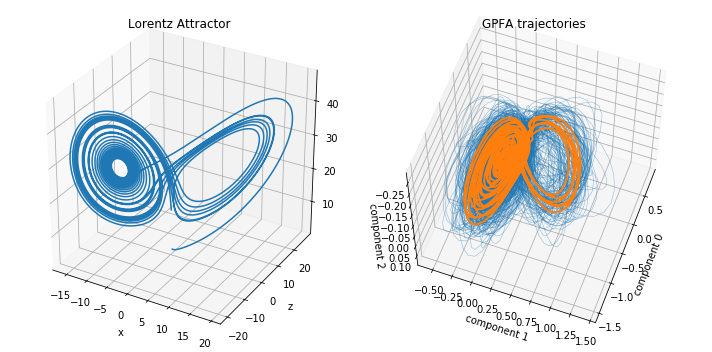

In [16]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.plot(lorentz_trajectory_3D[0], lorentz_trajectory_3D[1], lorentz_trajectory_3D[2])
ax1.set_title('Lorentz Attractor')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_ylabel('z')

# single trial trajectories
for i in range(num_trials):
    ax2.plot(xorth[i][0], xorth[i][1], xorth[i][2], '-', linewidth=linewidth_single_trial, color=color_single_trial, alpha=alpha_single_trial)

# trial averaged trajectories
average_trajectories = np.zeros_like(xorth[0])
for i in range(num_trials):
    average_trajectories += xorth[i]
average_trajectories /= num_trials
ax2.plot(average_trajectories[0], average_trajectories[1], average_trajectories[2], '-', linewidth=linewidth_trial_average, color=color_trial_average)
ax2.set_title('GPFA trajectories')
ax2.set_xlabel('component 0')
ax2.set_ylabel('component 1')
ax2.set_zlabel('component 2')

ax2.view_init(azim=-20, elev=-120)

plt.tight_layout()
plt.show()

Again, we see that GPFA found 3-dimensional subspace that follows Lorentz Attractor. Let's take a closer look at the dynamics of the "hidden" dimensions of GPFA and compare them with Lorentz X, Y, and Z trajectories in time.

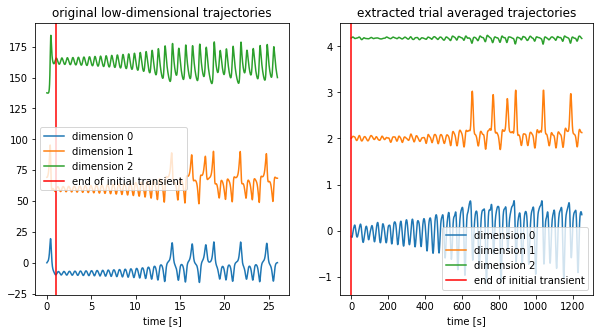

In [17]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

for i, x in enumerate(lorentz_trajectory_3D):
    ax1.plot(time_with_transient*timestep.rescale('s'), x+i*(np.max(lorentz_trajectory_3D)-np.min(lorentz_trajectory_3D)), label=f'dimension {i}')
ax1.axvline(transient_duration.rescale('s').magnitude, color='r',label='end of initial transient')
ax1.set_xlabel('time [s]')
ax1.set_title('original low-dimensional trajectories')
ax1.legend()

for i, x in enumerate(average_trajectories):
    ax2.plot(x+i*(np.max(average_trajectories)-np.min(average_trajectories)), label=f'dimension {i}')
ax2.axvline(transient_duration.rescale('s').magnitude, color='r',label='end of initial transient')
ax2.set_xlabel('time [s]')
ax2.set_title('extracted trial averaged trajectories')
ax2.legend()
plt.show()

## Cross-validation

The GPFA class is compatible to the cross-validation functions of `sklearn.model_selection`, such that users can perform cross-validation to search for a set of parameters yielding best performance using these functions. By default a call of the `sklearn.model_selection.cross_val_score(..., cv=5)` will invoque a five-fold cross validation.

Further below this will be done for several input dimensions to the GPFA in order to see, which dimension yields the best fit (largest log-likelihood). This cross-validation will be performed on the Lorentz attractor, so it is expected to see the maximal log-likelihood for three dimensions.

_Note. The following step is time consuming._

In [18]:
log_likelihoods = []
for x_dim in range(1, 6):
    gpfa = GPFA(x_dim=x_dim, verbose=False)
    log_likelihoods.append(np.mean(cross_val_score(gpfa, synthetic_spiketrains_lorentz, cv=5)))

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 345 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 390 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 370 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 375 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 395 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor ana

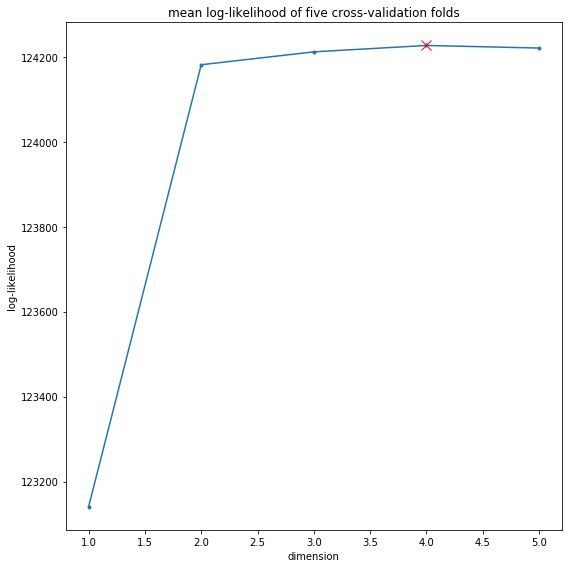

In [20]:
f = plt.figure(figsize=(8,8))
plt.title('mean log-likelihood of five cross-validation folds')
plt.plot(range(1,6), log_likelihoods, '.-')
plt.plot(np.argmax(log_likelihoods)+1, np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.xlabel('dimension')
plt.ylabel('log-likelihood')
plt.tight_layout()
plt.show()

The red cross denotes the maximum log-likelihood, which in our Lorentz example corresponds to the first 4 dimensions of GPFA subspace. However, in practice you will use more sophisticated methods (e.g. deviance information criterion (DIC), not shown here) to get an effective number of parameters (GPFA dimensions) that rewards log-likelihood and penalizes model complexity.